#### Import the facialextractor

In [1]:
from facialextractor import FacialExtractor
from glob import glob
import random
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

2024-08-02 14:48:09.220689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 14:48:09.227993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 14:48:09.238554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 14:48:09.238570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 14:48:09.245667: I tensorflow/core/platform/cpu_feature_gua

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

#### Load random image

In [3]:
puredt_path = '/mnt/disk2/PURE'

In [4]:
# random subject from 1 - 10
ran_sub = random.randint(1, 10)
ran_rec = random.randint(1, 6)

# change the format into two digits
folder_name = str(ran_sub).zfill(2) + '-' + str(ran_rec).zfill(2)

# override folder_name
folder_name = '01-03'
print(f"Folder name: {folder_name}")



# populate the `png` files
png_files = os.listdir(os.path.join(puredt_path, folder_name))
print(f"Total number of files: {len(png_files)}")

Folder name: 01-03
Total number of files: 2481


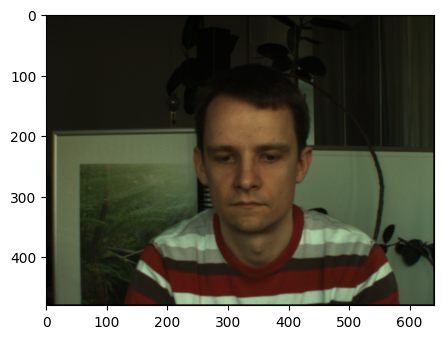

In [5]:
# select a random image
ran_img = random.choice(png_files)
img = cv2.imread(os.path.join(puredt_path, folder_name, ran_img))
img_prv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img_prv); plt.axis('on'); plt.show()

#### Try the `detect_face_bbox`

In [6]:
facial_extractor = FacialExtractor()
bbox = facial_extractor.detect_face_bbox(image=img)

I0000 00:00:1722581290.962863 1452696 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722581291.036302 1459943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.23.08), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1722581291.054644 1459923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722581291.058411 1459929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


visualize the bbox

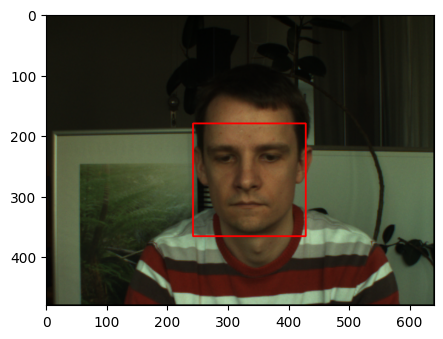

Bounding box width: 186 | height: 186


: 

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(cv2.rectangle(img_prv, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)); plt.axis('on'); plt.show()
# calculate the bbox width and height
bbox_width = bbox[2] - bbox[0]
bbox_height = bbox[3] - bbox[1]
print(f"Bounding box width: {bbox_width} | height: {bbox_height}")


#### Try to mask the face

In [ ]:
cropped_face = facial_extractor.crop_img(image=img, bbox=bbox, expandbbox=2.0, out_size=(225, 225))

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(cropped_face); plt.axis('on'); plt.show()
print(f"Cropped face shape: {cropped_face.shape}")

#### Try to detect the interest point

In [ ]:
interest_point = facial_extractor.detect_lm(image=cropped_face)
cropped_face_prev = cropped_face.copy()
print(f"Interest point: {interest_point}")

In [ ]:
# visualize the interest point
plt.figure(figsize=(5, 5))
plt.imshow(cropped_face_prev)
for i, point in enumerate(interest_point):
    plt.scatter(point[0], point[1], c='r', s=10)

#### Segment Face

In [ ]:
masks, scores, logits = facial_extractor.segment_face(
    image=cropped_face,
    interest_point=interest_point,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(cropped_face)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

#### Extract Face Skin

In [ ]:
face_skin_img = facial_extractor.extract_face_skin(
    image=cropped_face,
    mask=masks,
)

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(face_skin_img); plt.axis('on'); plt.show()

### Try the tracker

In [ ]:
img_path = os.path.join(puredt_path, folder_name)
print(f"Image path: {img_path}")

In [ ]:
img_files = sorted(glob(os.path.join(img_path, '*.*')))
img_files = [f for f in img_files if f.endswith(("jpg", "jpeg", "png"))]

# read the image -> convert to RGB -> append to numpy array
images = []
for img_file in img_files:
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    
# convert the list into numpy array
images = np.array(images)

In [ ]:
facial_extractor = FacialExtractor(expandbbox=2.0)
bboxes = facial_extractor.track_img_frames(images=images, use_klt=False, dlib_interval=30)

In [ ]:
img_files = sorted(glob(os.path.join(img_path, "*.*")))
img_files = [f for f in img_files if f.endswith(("jpg", "jpeg", "png"))]
print(f"Total number of files: {len(img_files)} | Total number of bounding boxes: {len(bboxes)}")

Check the bbox movement

In [ ]:
# plot the bbox movement for its x and y axis.
# Create two subplots for this

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot([bbox[0] for bbox in bboxes], label='x-axis')
ax[1].plot([bbox[1] for bbox in bboxes], label='y-axis')
ax[0].set_title("X-axis movement")
ax[1].set_title("Y-axis movement")
plt.show()

In [ ]:
facial_extractor.preview_tracking(
    image_paths = img_files,
    bboxes = bboxes,
    num_frames=20,
)

### Final Pipeline: `process_img_frames`

In [30]:
facial_extractor = FacialExtractor()
img_path = os.path.join(puredt_path, folder_name)
all_face_skins = facial_extractor.process_img_frames(
    image_path = img_path,
    use_klt=True,
    dlib_interval=0.5,
    landmark_interval=0.2,
    segment_interval=0.2,
    winSize=(20, 20),
    maxLevel=1,
    minDistance=7,
    maxCorners=75,
    smoothing_window=5,
    verbose=True,
    # out_size=(256, 256),
)

I0000 00:00:1722481933.164146  882322 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722481933.209086  887790 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.23.08), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1722481933.210764  887776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722481933.214205  887789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Reading images from /mnt/disk2/PURE/01-03...
Found 2481 image files.
Time taken: 0.00 seconds
Tracking face movement in the image frames...
Time taken: 0.68 seconds
Frame 0 / 2481| Crop: 0.33 ms | Landmark: 6.36 ms | Segment: 412.89 ms | Extract: 0.56 ms
Frame 173 / 2481| Crop: 0.15 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.50 ms
Frame 346 / 2481| Crop: 0.16 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.49 ms
Frame 519 / 2481| Crop: 0.17 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.52 ms
Frame 692 / 2481| Crop: 0.15 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.50 ms
Frame 865 / 2481| Crop: 0.18 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.55 ms
Frame 1038 / 2481| Crop: 0.15 ms | Landmark: 5.26 ms | Segment: 419.56 ms | Extract: 0.57 ms
Frame 1211 / 2481| Crop: 0.15 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.50 ms
Frame 1384 / 2481| Crop: 0.14 ms | Landmark: 0.00 ms | Segment: 0.00 ms | Extract: 0.48 ms
Frame 1557 / 2481| C

In [31]:
# save numpy array as file
np.save(os.path.join('./', 'masked-01-03.npy'), all_face_skins)

In [11]:
print(f"Shape of all face skins: {all_face_skins.shape} | Type: {type(all_face_skins)}")

Shape of all face skins: (2279, 224, 224, 3) | Type: <class 'numpy.ndarray'>


### Preview as Image

In [ ]:
sample_img = all_face_skins[255]
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(sample_img); plt.axis('on'); plt.show()

### Preview as Video

In [32]:
def create_video_from_numpy(frames, output_path, fps=30):
    """
    Create an MP4 video from a numpy array of frames.

    Args:
        frames (numpy.ndarray): 4D array of frames (num_frames x height x width x channels)
        output_path (str): Path where the output video will be saved
        fps (int): Frames per second for the output video

    Returns:
        None
    """
    # Get the dimensions of the frames
    num_frames, height, width, channels = frames.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i in range(num_frames):
        out.write(frames[i])

    # Release the VideoWriter
    out.release()

    print(f"Video saved to {output_path}")

In [33]:
output_path = "01-03.mp4"
fps = 30  # You can adjust this value as needed

create_video_from_numpy(all_face_skins, output_path, fps)

Video saved to 01-03.mp4
